# Bird Simulation Evaluation Script

## Imports & Preparations

In [1]:
import numpy as np
import birds
import argparse
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PathCollection
from IPython.display import HTML
%matplotlib inline

## Run with these Settings

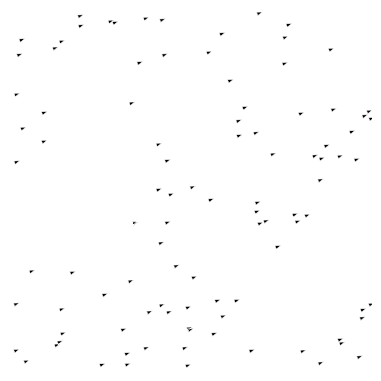

In [4]:
frames = 1000
birds.param_record = False
birds.trace = None
flock = birds.Flock()
fig = plt.figure(figsize=(5, 5*flock.args['height']/flock.args['width']), facecolor="white")
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], aspect=1, frameon=False)
birds.collection = birds.MarkerCollection(flock.args['n'])
ax.add_collection(birds.collection._collection)
ax.set_xlim(0, flock.args['width'])
ax.set_ylim(0, flock.args['height'])
ax.set_xticks([])
ax.set_yticks([])

animation = FuncAnimation(fig, birds.update, interval=10, frames=frames)
HTML(animation.to_html5_video())


## Find moving phase

## Run with varying Eta

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

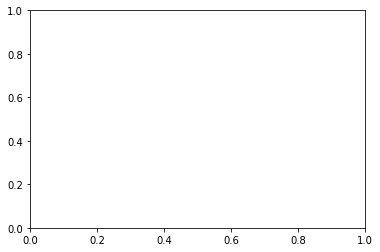

In [6]:
res = 10
time = range(500)
repeat = 1
rho=4
Eta = np.linspace(0.,5.,res)
N = [40,100,400]
#N = [40,100,400,4000,10000]

va = np.zeros((len(N),res))
vas = np.zeros(repeat)
for c,n in enumerate(N):
    for i,eta in enumerate(Eta):
        for j in range(repeat):
            f = birds.Flock(n=n,eta=eta,rho=rho)
            for t in time:
                f.run()
            vas[j] = f.get_va()
        va[c][i] = vas.sum()/repeat
        
for c,n in enumerate(N):
    plt.plot(eta,va[c],label="N="+str(n))
plt.xlabel("eta")
plt.ylabel("v_a")
plt.legend()
plt.title("v_a over \eta at n="+str(n)+", L="+str(L))